# Baseline code
This code introduces a two-step training for the problem. It may be better doing only one-step, i.e. from noisy patch to descriptor directly, but this provides an initial valid submission to use as a first step.

The outputs you see here are with only some minutes of training, so results should be better if the models are trained for more time.



## Initial check

We first check the amount of memory we have in the notebook. Usually, we have available 11.4 GB of GPU memory, which is more than enough to run this code. However, some users reported having only 500 MB of GPU memory. If you have that amount, restart the environment to see if you get the corresponding 11.4 GB

In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [0]:
printm()

## Downloading functions and data

The first step is to clone a GitHub repository with some functions implemented, and also downloading and extracting the HPatches data. We can run command line commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we use to change directory (`cd`). It takes around 5 minutes to download and unzip the dataset. 


In [0]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

fatal: destination path 'keras_triplet_descriptor' already exists and is not an empty directory.


In [0]:
# Change directory
%cd /content/keras_triplet_descriptor    

/content/keras_triplet_descriptor


In [0]:
# Download data
# !wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


--2019-01-31 11:29:23--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 185.235.236.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-01-31 11:29:23--  https://imperialcollegelondon.app.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.com)... 185.235.236.199
Connecting to imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.com)|185.235.236.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!F1wozFGY2VETtrR0tmGJOc2MJ8TldjmkVnlr3GPd9SDjIkKdmHvqZLdfjGikqXGLB-1o_BsOc1V9

In [0]:
# Extract data
# !unzip -q ./hpatches_data.zip
# !rm ./hpatches_data.zip

## Importing necessary modules

We now import the modules we will use in this baseline code. The read_data and utils imports are function provided in the repository we just cloned.

In [0]:
import sys
import json
import os
import glob
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)
%pwd

u'/content/keras_triplet_descriptor'

The HPatches dataset has several splits, where it separates the sequences available in train sequences and test sequences. We load the split 'a'. 

In [0]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in test_fnames, seqs)) 



## Models and loss

We now define three functions that define main modules of our baseline. First, we have a function that returns a denoising model. The input for the function is the size of the patch, which will be 1x64x64, and it outputs a keras model.

Then we have a similar function for the descriptor model, the model we use as baseline takes as input a patch of size 1x32x32, and returns a descriptor. Then we will use the triplet loss.

You can modify the models in this functions and run the training code again for your new models. For example, the given UNet is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weigths. Or maybe adding dropout. Or modifying the loss somehow....

In [0]:
def get_denoise_model(shape):

    inputs = Input(shape)
    if mode==0:  # baseline
      conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
      pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
      ## Bottleneck
      conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

      ## Now the decoder starts
      up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
      merge3 = concatenate([conv1,up3], axis = -1)
      conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
      conv4 = Conv2D(1, 3,  padding = 'same')(conv3)
      
      model = Model(input = inputs, output = conv4)
      
    else if mode==1: # u-net
      conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
      conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
      pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
      conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
      conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
      pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
      conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
      conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
      pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
      conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
      conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
      drop4 = Dropout(0.5)(conv4)
      pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

      conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
      conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
      drop5 = Dropout(0.5)(conv5)

      up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
      merge6 = concatenate([drop4,up6], axis = 3)
      conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
      conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

      up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
      merge7 = concatenate([conv3,up7], axis = 3)
      conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
      conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

      up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
      merge8 = concatenate([conv2,up8], axis = 3)
      conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
      conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

      up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
      merge9 = concatenate([conv1,up9], axis = 3)
      conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
      conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
      conv9 = Conv2D(2, 3, padding = 'same')(conv9)

      model = Model(input = inputs, output = conv9)
      
    else if mode==2:
      
    
  return model


def get_descriptor_model(shape):
  '''Architecture copies HardNet architecture'''
  init_weights = keras.initializers.he_normal()
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(Reshape((128,)))
  return descriptor_model
  
  
def triplet_loss(x):
  output_dim = 128
  a, p, n = x
  _alpha = 1.0 # _alpha is the margin parameter
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

print('finished')

finished


## Denoising patches


We use the DenoiseHPatches class implemented in the read_data.py file, which takes as input the list of sequences to load. It outputs batches where the input data is the noisy image and the label is the clean image, so then we can use a mean absolute error metric (or MSE also works) as loss function. 

Here we take a subset of training and validation sequences by using random.sample (3 sequences for training and 1 for validation data). The purpose of doing so was just to speed-up training for generating faster the output of this notebook. Remove the random.sample function to give the generator all the training data.

In [0]:
denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
# denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 5), batch_size=50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)


100%|██████████| 40/40 [00:38<00:00,  1.04it/s]


In [0]:
shape = (32, 32, 1) # input image dimension
denoise_model = get_denoise_model(shape)

We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [0]:
printm()

('Gen RAM Free: 7.7 GB', ' | Proc size: 6.0 GB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
# sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
denoise_model.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
#denoise_history = denoise_model.fit(x=seqs_train,epochs=1,verbose=2,validation_split=0.25)
denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=1, verbose=1, validation_data=denoise_generator_val)
denoise_model.save_weights('denoise_adam_mae_epoch1_lr1e-3_bet0.9_bet0.999_ep1e8.h5') 

Epoch 1/1
22482/31179 [====================>.........] - ETA: 41:02 - loss: 8.3058 - mean_absolute_error: 8.3058

In [0]:
denoise_model.save_weights('denoise_sgd_mae_epoch1_lr1e-4_momen0.9.h5') 

You may want to save the weights in your local disk. To do so, use:



In [0]:
from google.colab import files
files.download('denoise_sgd_mae_epoch1_lr1e-4_momen0.9.h5')

### Visualization of denoising results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


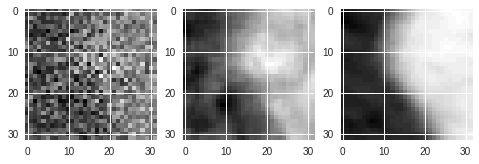

In [0]:
plot_denoise(denoise_model)

## Training a Descriptor Network
Now we train the network that generates the descriptors for the patch. We are going to use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

In [0]:
from keras.layers import Lambda
shape = (32, 32, 1) # input dimension
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en]) # arbitrary loss function as layer (by doing this we define our own loss function)

descriptor_model_trip = Model(inputs = [xa, xp, xn], outputs = loss)
sgd = keras.optimizers.SGD(lr = 0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Here we use the class HPatches, which loads the corresponding files by using the method read_image_file. It reads the clean patches, which are the ones used for training in this baseline code. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class DataGeneratorDesc. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

In [0]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames = train_fnames, test_fnames = test_fnames)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train = 1), num_triplets = 100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train = 0), num_triplets = 10000)


100%|██████████| 116/116 [00:36<00:00,  3.20it/s]


97435


100%|██████████| 116/116 [00:21<00:00,  4.07it/s]


59532


100%|██████████| 10000/10000 [00:00<00:00, 83077.90it/s]


We plot a random triplet in the form of anchor, positive and negative sample

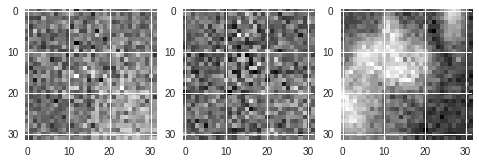

In [0]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [0]:
history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=10, verbose=1, validation_data=val_generator)
descriptor_model.save_weights('hardnet.h5') 

Epoch 1/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.1680

 75%|███████▌  | 75470/100000 [00:02<00:00, 28326.83it/s]

2000/2000 [==============================] - 157s 78ms/step - loss: 0.1680 - val_loss: 0.2141


 80%|████████  | 80245/100000 [00:03<00:00, 30527.69it/s]

Epoch 2/10


  0%|          | 0/10000 [00:00<?, ?it/s]

   1/2000 [..............................] - ETA: 58:55 - loss: 0.1496

 22%|██▏       | 2173/10000 [00:00<00:00, 21710.04it/s]

   2/2000 [..............................] - ETA: 30:47 - loss: 0.1320

 49%|████▉     | 4902/10000 [00:00<00:00, 23128.25it/s]

   3/2000 [..............................] - ETA: 21:27 - loss: 0.1506

 87%|████████▋ | 8712/10000 [00:00<00:00, 26218.79it/s]

   4/2000 [..............................] - ETA: 16:44 - loss: 0.1564

100%|██████████| 10000/10000 [00:00<00:00, 26935.65it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1501

 80%|████████  | 80389/100000 [00:02<00:00, 28419.43it/s]

2000/2000 [==============================] - 159s 79ms/step - loss: 0.1501 - val_loss: 0.1845


 87%|████████▋ | 86665/100000 [00:03<00:00, 29851.71it/s]

Epoch 3/10


 12%|█▏        | 1155/10000 [00:00<00:02, 3400.21it/s]

   1/2000 [..............................] - ETA: 1:19:15 - loss: 0.2695

 29%|██▊       | 2866/10000 [00:00<00:01, 4476.17it/s]

   2/2000 [..............................] - ETA: 40:56 - loss: 0.1748  

 70%|██████▉   | 6971/10000 [00:00<00:00, 6108.98it/s]

   4/2000 [..............................] - ETA: 21:43 - loss: 0.1802

100%|██████████| 10000/10000 [00:00<00:00, 15857.94it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1395

 82%|████████▏ | 81606/100000 [00:02<00:00, 30762.23it/s]

2000/2000 [==============================] - 159s 79ms/step - loss: 0.1394 - val_loss: 0.1685


 87%|████████▋ | 87040/100000 [00:03<00:00, 35364.97it/s]

Epoch 4/10


  0%|          | 0/10000 [00:00<?, ?it/s]

   1/2000 [..............................] - ETA: 52:57 - loss: 0.1457

 23%|██▎       | 2287/10000 [00:00<00:00, 22860.87it/s]

   2/2000 [..............................] - ETA: 27:46 - loss: 0.1353

 65%|██████▍   | 6472/10000 [00:00<00:00, 26462.90it/s]

   3/2000 [..............................] - ETA: 19:24 - loss: 0.1024

100%|██████████| 10000/10000 [00:00<00:00, 31720.46it/s]

   4/2000 [..............................] - ETA: 15:28 - loss: 0.0876

1999/2000 [============================>.] - ETA: 0s - loss: 0.1344

 81%|████████  | 80814/100000 [00:03<00:00, 29431.39it/s]

2000/2000 [==============================] - 158s 79ms/step - loss: 0.1344 - val_loss: 0.1588


 85%|████████▍ | 84863/100000 [00:03<00:00, 31367.95it/s]

Epoch 5/10


 40%|████      | 4032/10000 [00:00<00:01, 5487.82it/s]

   1/2000 [..............................] - ETA: 1:06:14 - loss: 0.0695

 60%|██████    | 6007/10000 [00:00<00:00, 6950.45it/s]

   2/2000 [..............................] - ETA: 34:28 - loss: 0.0377  

 83%|████████▎ | 8324/10000 [00:00<00:00, 8797.96it/s]

   3/2000 [..............................] - ETA: 23:53 - loss: 0.0486

100%|██████████| 10000/10000 [00:00<00:00, 11031.15it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1292

 79%|███████▉  | 79335/100000 [00:02<00:00, 31965.06it/s]

2000/2000 [==============================] - 160s 80ms/step - loss: 0.1292 - val_loss: 0.1707


 84%|████████▎ | 83667/100000 [00:03<00:00, 32380.00it/s]

Epoch 6/10


  0%|          | 0/10000 [00:00<?, ?it/s]

   1/2000 [..............................] - ETA: 55:33 - loss: 0.0548

 18%|█▊        | 1782/10000 [00:00<00:00, 17815.90it/s]

   2/2000 [..............................] - ETA: 29:15 - loss: 0.0627

 58%|█████▊    | 5796/10000 [00:00<00:00, 21383.22it/s]

   3/2000 [..............................] - ETA: 20:24 - loss: 0.0975

100%|██████████| 10000/10000 [00:00<00:00, 30580.85it/s]

   4/2000 [..............................] - ETA: 15:57 - loss: 0.0951

1999/2000 [============================>.] - ETA: 0s - loss: 0.1246

 78%|███████▊  | 78343/100000 [00:02<00:00, 29303.90it/s]

2000/2000 [==============================] - 159s 79ms/step - loss: 0.1246 - val_loss: 0.1658


 83%|████████▎ | 83322/100000 [00:02<00:00, 31330.80it/s]

Epoch 7/10


 68%|██████▊   | 6849/10000 [00:00<00:00, 6515.23it/s]

   1/2000 [..............................] - ETA: 1:14:50 - loss: 0.0836

100%|██████████| 10000/10000 [00:01<00:00, 9701.39it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1184

 77%|███████▋  | 77361/100000 [00:02<00:00, 29778.06it/s]

2000/2000 [==============================] - 159s 80ms/step - loss: 0.1183 - val_loss: 0.1602


 82%|████████▏ | 82449/100000 [00:03<00:00, 34009.52it/s]

Epoch 8/10


100%|██████████| 100000/100000 [00:04<00:00, 23222.20it/s]


   1/2000 [..............................] - ETA: 53:24 - loss: 0.1849

  0%|          | 0/10000 [00:00<?, ?it/s]

   3/2000 [..............................] - ETA: 19:32 - loss: 0.1377

 38%|███▊      | 3778/10000 [00:00<00:00, 37758.79it/s]

   4/2000 [..............................] - ETA: 15:18 - loss: 0.1518

 71%|███████   | 7112/10000 [00:00<00:00, 36314.17it/s]

   5/2000 [..............................] - ETA: 12:45 - loss: 0.1375

100%|██████████| 10000/10000 [00:00<00:00, 30669.85it/s]

   6/2000 [..............................] - ETA: 11:16 - loss: 0.1186

1999/2000 [============================>.] - ETA: 0s - loss: 0.1129

 84%|████████▎ | 83594/100000 [00:03<00:00, 31019.96it/s]

2000/2000 [==============================] - 158s 79ms/step - loss: 0.1130 - val_loss: 0.1438


 88%|████████▊ | 87806/100000 [00:03<00:00, 33682.37it/s]

Epoch 9/10


  0%|          | 0/10000 [00:00<?, ?it/s]

   1/2000 [..............................] - ETA: 51:10 - loss: 0.0950

 14%|█▎        | 1369/10000 [00:00<00:00, 13686.16it/s]

   2/2000 [..............................] - ETA: 26:57 - loss: 0.1337

 48%|████▊     | 4786/10000 [00:00<00:00, 16687.03it/s]

   3/2000 [..............................] - ETA: 18:52 - loss: 0.1725

 77%|███████▋  | 7676/10000 [00:00<00:00, 19108.40it/s]

   4/2000 [..............................] - ETA: 14:46 - loss: 0.1467

100%|██████████| 10000/10000 [00:00<00:00, 27068.01it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1108

 77%|███████▋  | 76967/100000 [00:03<00:00, 29253.53it/s]

2000/2000 [==============================] - 158s 79ms/step - loss: 0.1108 - val_loss: 0.1520


 81%|████████▏ | 81396/100000 [00:03<00:00, 30618.84it/s]

Epoch 10/10


  0%|          | 0/10000 [00:00<?, ?it/s]

   1/2000 [..............................] - ETA: 58:02 - loss: 0.1329

 43%|████▎     | 4314/10000 [00:00<00:00, 43128.32it/s]

   2/2000 [..............................] - ETA: 30:19 - loss: 0.0812

 79%|███████▉  | 7939/10000 [00:00<00:00, 40805.35it/s]

   3/2000 [..............................] - ETA: 21:10 - loss: 0.0858

100%|██████████| 10000/10000 [00:00<00:00, 35919.67it/s]

   4/2000 [..............................] - ETA: 16:33 - loss: 0.0811

1999/2000 [============================>.] - ETA: 0s - loss: 0.1113

 82%|████████▏ | 81873/100000 [00:02<00:00, 30018.75it/s]

2000/2000 [==============================] - 158s 79ms/step - loss: 0.1112 - val_loss: 0.1510


100%|██████████| 10000/10000 [00:00<00:00, 12841.90it/s]


## Generating descriptors files for test data 

HPatches benchmark takes as input the descriptors for the test data in a CSV form. This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to None), the descriptor is computed directly in the noisy patch.

In [0]:
generate_desc_csv(descriptor_model, denoise_model, seqs_test)

100%|██████████| 40/40 [06:26<00:00,  9.25s/it]


## Evaluating descriptors in HPatches Benchmark
We first download the official repository for HPatches Benchmark.

In [0]:
!git clone https://github.com/hpatches/hpatches-benchmark


Cloning into 'hpatches-benchmark'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 1435 (delta 11), reused 14 (delta 5), pack-reused 1409
Receiving objects: 100% (1435/1435), 239.72 MiB | 20.62 MiB/s, done.
Resolving deltas: 100% (789/789), done.
Checking out files: 100% (135/135), done.


Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script.

### Verification



In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=verification



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:24<00:00, 11893.15it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:23<00:00, 12029.05it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:24<00:00, 11835.86it/s]
>> Verification task finished in 260 secs  
Verification task results:
CUSTOM - Balanced variant (auc) 
Noise       Inter     Intra
-------  --------  --------
Easy     0.952802  0.927342
Hard     0.935712  0.90286
Tough    0.907797  0.866072
CUSTOM - Imbalanced variant (ap) 
Noise       Inter     Intra
-------  --------  --------
Easy     0.884978  0.826117
Hard     0.83224   0.748747
Tough    0.752166  0.650537




### Matching

In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=matching



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:12<00:00,  4.48s/it]
>> Matching task finished in 132 secs  
Matching task results:
CUSTOM - mAP 
    Easy      Hard      Tough      mean
--------  --------  ---------  --------
0.329607  0.150999  0.0608267  0.180477






### Retrieval

In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=retrieval



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x55a994f26000 @  0x7f5831f271e7 0x7f5827b28cf1 0x7f5827b8b3a2 0x7f5827b8d0de 0x7f5827c240e8 0x55a96e8f6fe5 0x55a96e8ecd0a 0x55a96e8f45fe 0x55a96e8f4232 0x55a96e8ecd0a 0x55a96e8f4c38 0x55a96e8ecd0a 0x55a96e8ec629 0x55a96e91d61f 0x55a96e918322 0x55a96e91767d 0x55a96e8c61ab 0x7f5831b24b97 0x55a96e8c5a2a
>> Distance matrix done.
Processing retrieval task: 100% 10000/10000 [03:58<00:00, 41.28it/s]
>> Retrieval task finished in 257 secs  
Retrieval task results:
CUSTOM - mAP 10K queries 
Noise         100       500      1000      5000     10000     15000     20000
-------  --------  --------  --------  --------  --------  --------  --------
Easy     0.832393  0.718672  0.671093  0.560876  0.515329  0.489569  0.473572
Hard     0.785755  0.620193  0.549975  0.3928

## Compressing and saving the CSV files 

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [0]:
# !zip -rq descriptors.zip ./out/custom
!zip -r descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [0]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')

File ID: 1-e2KuQ39Lgc26EzcwVu3drBeBk4aKmFd


{u'id': u'1-e2KuQ39Lgc26EzcwVu3drBeBk4aKmFd'}